In [5]:
import os
os.getcwd() 
os.chdir(os.pardir)
os.getcwd()



'/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning'

# Statistical test

In [4]:
os.getcwd()

'/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning'

In [6]:
# None of the checkpoints could be used since they are not compatible with the current codebase.
# Therefore I have the losses, and I will compare them statisticallly with a t-test.
from scipy.stats import ttest_rel, ttest_ind, wilcoxon
import pandas as pd
loss_ebm_df = pd.read_csv(os.getcwd() + '/result/ebmloss.csv')
loss_ebm128_df = pd.read_csv(os.getcwd() + '/result/ebm128loss.csv')



In [7]:
loss_ebm = loss_ebm_df.iloc[:, -1]
loss_ebm128 = loss_ebm128_df.iloc[:, -1]


In [10]:
print("EBM vs EBM128")
print('shape:', loss_ebm.shape, loss_ebm128.shape)

# The loss values are not normally distributed, so we will use wilcoxon.
print('Same datapoints for both models therefore paired test')
print("Performing paired t-test...")
t_stat, p_value = ttest_rel(loss_ebm128[0:len(loss_ebm)], loss_ebm)
print(f't-statistic: {t_stat}, p-value: {p_value}')
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

print("Performing wilcoxon...")
wilcoxon_stat, wilcoxon_p_value = wilcoxon(loss_ebm128[0:len(loss_ebm)], loss_ebm)
print(f'wilcoxon-statistic: {wilcoxon_stat}, p-value: {wilcoxon_p_value}')
if wilcoxon_p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")


EBM vs EBM128
shape: (7886,) (8365,)
Same datapoints for both models therefore paired test
Performing paired t-test...
t-statistic: 29.867210715133076, p-value: 8.677852054921298e-186
The difference is statistically significant.
Performing wilcoxon...
wilcoxon-statistic: 76120.0, p-value: 0.0
The difference is statistically significant.


# Combine components

In [31]:
import torch
import numpy as np
from src.comet_models import LatentEBM
from src.config.load_config import load_config

def gen_image(latents, models, im_neg, num_steps, idx=None):
    im_negs = []

    im_neg.requires_grad_(requires_grad=True)

    for i in range(num_steps):
        energy = 0

        for j in range(len(latents)):
            if idx is not None and idx != j:
                pass
            else:
                energy = models[0].forward(im_neg, latents[j]) + energy
        im_grad, = torch.autograd.grad([energy.sum()], [im_neg])

        im_neg = im_neg - 100 * im_grad

        im_neg = torch.clamp(im_neg, 0, 1)
        im_negs.append(im_neg)
        im_neg = im_neg.detach()
        im_neg.requires_grad_()

    return im_negs



In [32]:


# 1. Load config and model
config_path = "/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/config/testebm128.yml"
checkpoint_path = "/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/models/ebm128_models_7800_5:6.pt"
config = load_config(config_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LatentEBM(config, 'MRI2D').to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['ebm_state'][0])  # Use the first model if it's an ensemble
model.eval()

# 2. Load latent vectors
un814_latents = np.load('/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/result/latents/MRI2D_latents_UN814_is=50.npy')
un816_latents = np.load('/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/result/latents/MRI2D_latents_ebm128_models_7800_5:6.npy')

# 3. Combine latents as needed (example: stack first latent from each)
combined_latents = np.stack([un814_latents, un816_latents], axis=0)
combined_latents = torch.tensor(combined_latents, dtype=torch.float32).to(device)




In [35]:
im_neg = torch.rand(1, 228, 198).requires_grad_(True)
steps = 10
print(combined_latents.shape)
recons = gen_image(combined_latents, [model], im_neg, steps)

torch.Size([2, 12, 512])


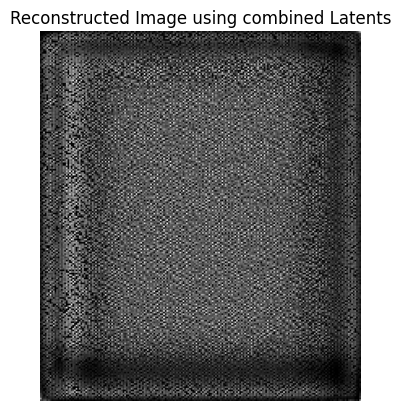

In [45]:
import matplotlib.pyplot as plt
plt.imshow(recons[1].detach().cpu().numpy()[0], cmap='gray')
plt.axis('off')
plt.title('Reconstructed Image using combined Latents')
plt.show()

In [58]:
# Flatten the latent space for t-SNE
from torch.utils.data import DataLoader
from src.ae import NumpyMRIDataset
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



dataset = NumpyMRIDataset(root="data/")
if len(dataset) == 0:
    raise ValueError("Dataset is empty. Please check the data path and ensure it contains images.")

dataloader = DataLoader(dataset, batch_size=20)
im = next(iter(dataloader))
images = im.to(device)
print(f"Images shape: {images.shape}")

latents_flat = combined_latents.view(combined_latents.size(0), -1).cpu().numpy()
print(f"Latents flattened shape: {latents_flat.shape}")
print(f"Latents original shape: {combined_latents.shape}")

# Perform t-SNE
perplex = min(30, latents_flat.shape[0] - 1)
print(f"Perplexity: {perplex}")
tsne = TSNE(n_components=2, random_state=42, perplexity=perplex)  # Reduce to 2 dimensions for visualization
latents_tsne = tsne.fit_transform(latents_flat)


Images shape: torch.Size([20, 1, 256, 256])
Latents flattened shape: (2, 6144)
Latents original shape: torch.Size([2, 12, 512])
Perplexity: 1


IndexError: index 2 is out of bounds for axis 0 with size 2

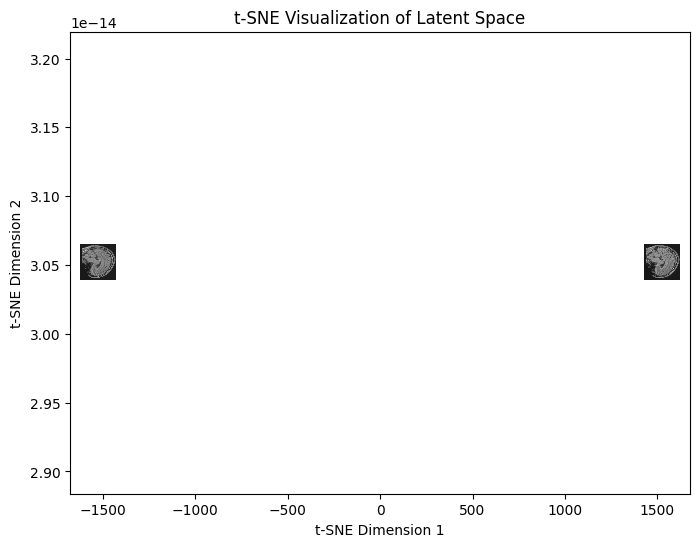

In [54]:

# Visualize the t-SNE results
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(latents_tsne[:, 0], latents_tsne[:, 1])
ax.set_title("t-SNE Visualization of Latent Space")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")

# Function to create an image annotation
def imscatter(x, y, images, ax=None, zoom=0.1):
    if ax is None:
        ax = plt.gca()
    for i in range(len(images)):
        img = images[i].squeeze().cpu().numpy()
        imagebox = OffsetImage(img, cmap="gray", zoom=zoom)
        ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
        ax.add_artist(ab)

# Overlay images on the t-SNE plot
imscatter(latents_tsne[:, 0], latents_tsne[:, 1], images, ax=ax)
plt.tight_layout()
plt.savefig("latent_tsne_visualization_ae_wskips.png", dpi=600)
plt.show()


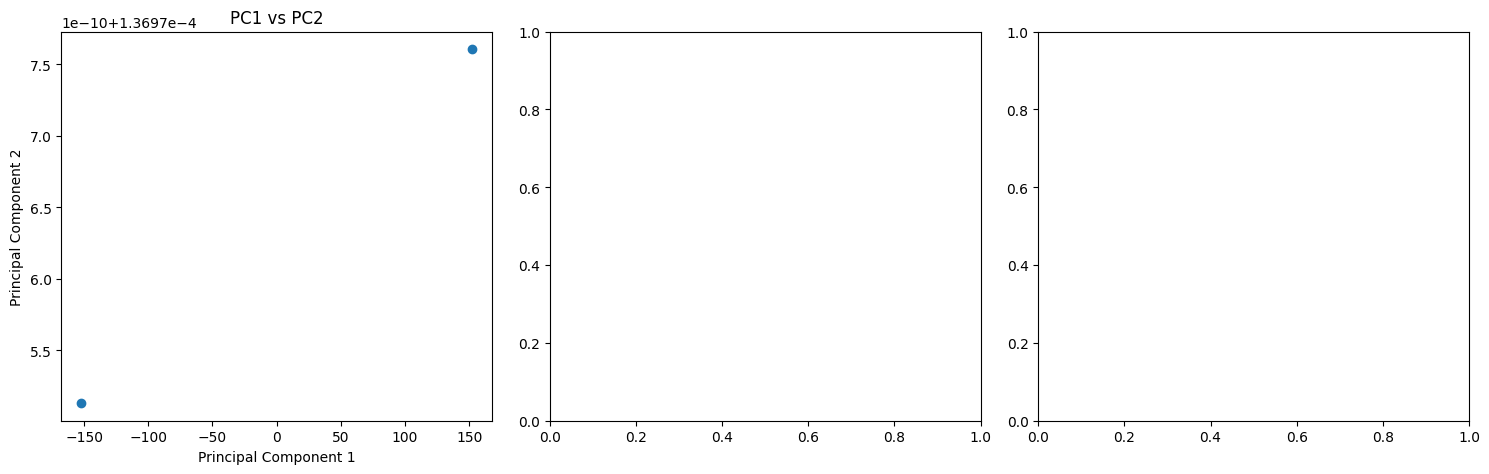

In [56]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=latents_flat.shape[0])
latents_pca = pca.fit_transform(latents_flat)

# Visualize the PCA results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot PC1 vs PC2
axes[0].scatter(latents_pca[:, 0], latents_pca[:, 1])
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].set_title("PC1 vs PC2")


plt.tight_layout()
plt.show()
